In [1]:
import khmer
# ref = https://github.com/dib-lab/khmer/blob/master/examples/python-api/exact-counting.py
import tqdm
import pandas as pd
import numpy as np
import os
import scanpy.api as sc
import anndata as ad
from scipy import sparse
from plotnine import *
import plotnine
from IPython.core.display import HTML


def file_len(fname):
    with open(fname) as f:
        for i, l in enumerate(f):
            pass
    return i + 1

In [2]:
dir_path = '/home/ubuntu/data/longread/'
ksize = 5
nkmers = 4**ksize

entry_len_list = []
for fn in os.listdir(dir_path):
    if fn.endswith('.fa') and fn != 'markers.fa':
        entry_len_list = entry_len_list+[int(file_len(f'{dir_path}{fn}')/2)]

entry_len_sum = int(np.sum(entry_len_list))
min_entry_len = int(np.min(entry_len_list))
balanced_entry_len_sum = int(min_entry_len*len(entry_len_list))

cell_df = pd.DataFrame()
master_df = pd.DataFrame()
kmer_arr = np.zeros((nkmers, balanced_entry_len_sum))

arr_idx = 0
seq_id_arr = np.zeros((balanced_entry_len_sum), dtype = 'object')
cell_id_arr = np.zeros((balanced_entry_len_sum), dtype = 'object')

# ingest all .fa files from dir
for fn in os.listdir(dir_path):
    if fn.endswith('.fa') and fn != 'markers.fa':
    
        # extract fn prefix for cell id
        cell_id = fn.split('.fa')[0]

        # read .fa
        with open(f'{dir_path}{fn}', 'r') as f:

            # random downsample to smallest fn
            for i, l in enumerate(f):
                pass
            
            entry_len = int((i+1)/2)
            entry_white_list = np.random.choice([x*2 for x in range(entry_len)], 
                                                min_entry_len,
                                                replace = False
                                               ).tolist()
            entry_white_list = [x+1 for x in entry_white_list]+entry_white_list

        with open(f'{dir_path}{fn}', 'r') as f:
            
            # parse entry by entry
            for count, line in tqdm.tqdm(enumerate(f, start=0)):

                # filter on whitelist
                if count in entry_white_list:

                    # extract first line as seq id
                    if count % 2 == 0:
                        k_name = line[1:-1]

                    # extract second line as sequence
                    if count % 2 != 0:

                        # Initialize countgraph
                        tablesize = nkmers + 10
                        ktable = khmer.Countgraph(ksize, tablesize, 1)

                        # count all k-mers in the given string
                        ktable.consume(line[:-1])

                        # capture full kmer counts
                        k_n_list = [ktable.get(i) for i in range(nkmers)]

                        # update kmer count arr
                        kmer_arr[:,arr_idx] = k_n_list 

                        # log sequence and cell names for metadata
                        seq_id_arr[arr_idx] = k_name
                        cell_id_arr[arr_idx] = cell_id

                        # update arr pointer
                        arr_idx = arr_idx + 1

# create dfs
kmers_list = [ktable.reverse_hash(i) for i in range(nkmers)]
master_df = pd.DataFrame(kmer_arr)
master_df['kmers'] = kmers_list
master_df = master_df.set_index('kmers')
master_df.columns = seq_id_arr.tolist()
cell_df = pd.DataFrame({'seq_id':seq_id_arr,
                        'cell_id':cell_id_arr,
                       })
cell_df = cell_df.set_index('seq_id')


3326it [00:00, 5807.27it/s]
11746it [00:01, 10863.71it/s]
34966it [00:02, 13612.14it/s]
9786it [00:01, 9138.46it/s] 
10186it [00:01, 9901.66it/s]
7562it [00:00, 9092.94it/s] 
4412it [00:00, 6647.19it/s]
3540it [00:00, 5909.49it/s]
12092it [00:01, 10270.35it/s]
6410it [00:00, 7710.51it/s]
5326it [00:00, 7258.76it/s]
6058it [00:00, 8270.17it/s]


In [3]:
# ingest data to adata obj

# pd df to np array
array_adata = master_df.values

# extract obs and var
obs = master_df.columns.tolist()
gene_names = master_df.index.tolist()

# create ad obj
adata = ad.AnnData(X=array_adata).T
adata.X = sparse.csr_matrix(adata.X)
adata.var_names = gene_names
adata.obs_names = obs

# append metadata
adata.obs['cell_id'] = cell_df.cell_id.tolist()

# transform and freeze raw state
adata.raw = sc.pp.log1p(adata, copy=True)

# embed and cluster
n_pcs = 10
n_neighbs = 15
min_dist = 0.5

all_forms_adata = sc.pp.log1p(adata, copy=True) 
sc.pp.scale(all_forms_adata) 
sc.tl.pca(all_forms_adata, use_highly_variable = False, n_comps=n_pcs, random_state=1) 
sc.pp.neighbors(all_forms_adata, n_pcs=n_pcs, n_neighbors = n_neighbs, random_state=1) 
sc.tl.umap(all_forms_adata, min_dist = min_dist, random_state=1)


/home/ubuntu/anaconda3/lib/python3.7/site-packages/umap/rp_tree.py:450: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "make_euclidean_tree" failed type inference due to: Cannot unify RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none) and RandomProjectionTreeNode(none, bool, array(float32, 1d, C), float64, RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none), RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none)) for '$14.16', defined at /home/ubuntu/anaconda3/lib/python3.7/site-packages/umap/rp_tree.py (457)

File "../../anaconda3/lib/python3.7/site-packages/umap/rp_tree.py", line 457:
def make_euclidean_tree(data, indices, rng_state, leaf_size=30):
    <source elided>

        left_node = make_euclidean_tree(data, left_indices, rng_state, leaf_size)
        ^

[1] During: resolving callee type: recursive(type(CPUDispatcher(<function make_euclidean_tree at 0x7f327

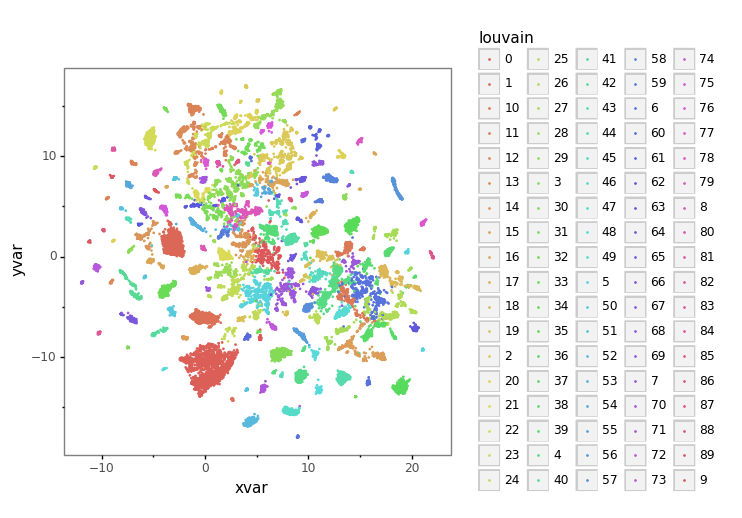

<ggplot: (8740927434728)>


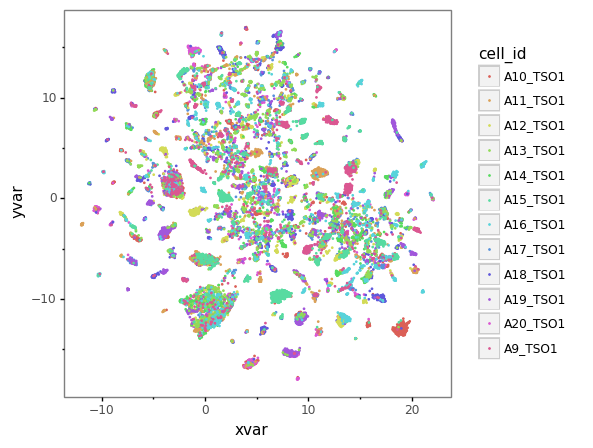

<ggplot: (8740908571119)>


In [8]:
louvain_res = 1
sc.tl.louvain(all_forms_adata, resolution = louvain_res, random_state=1)

umap_df = pd.DataFrame(all_forms_adata.obsm['X_umap'], columns = ['xvar','yvar'])
umap_df['cell_id'] = all_forms_adata.obs.cell_id.tolist()
umap_df['seq_id'] = all_forms_adata.obs.index.tolist()
umap_df['louvain'] = all_forms_adata.obs.louvain.tolist()

plotnine.options.figure_size = (5,5)
plot = (ggplot(umap_df)
        + theme_bw()
        + theme(aspect_ratio = 1,
                panel_grid_major = element_blank(), 
                panel_grid_minor = element_blank()
               )
        + geom_point(aes('xvar','yvar',color='louvain'), size=0.1)
       )
print(plot)

plot = (ggplot(umap_df)
        + theme_bw()
        + theme(aspect_ratio = 1,
                panel_grid_major = element_blank(), 
                panel_grid_minor = element_blank()
               )
        + geom_point(aes('xvar','yvar',color='cell_id'), size=0.1)
       )
print(plot)

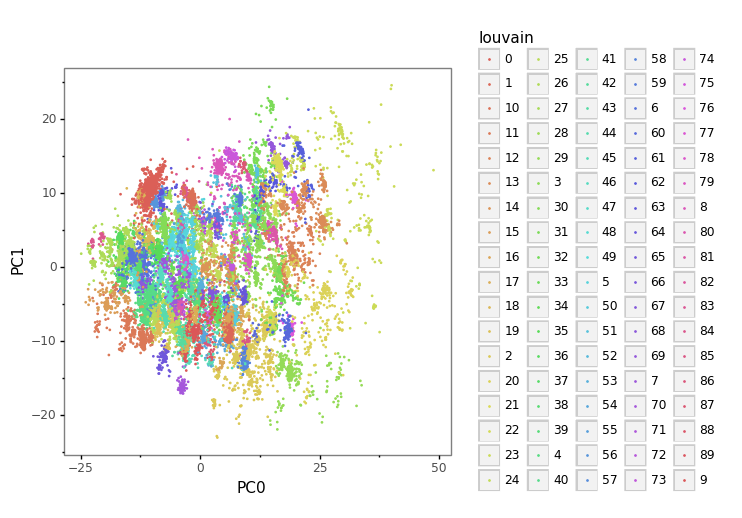

<ggplot: (8740927208312)>


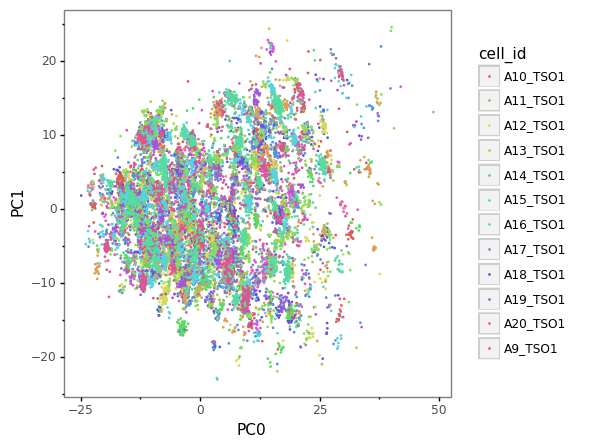

<ggplot: (8740925985193)>


In [9]:
pcx = 0
pcy = 1
pca_df = pd.DataFrame(all_forms_adata.obsm['X_pca'][:,[pcx, pcy]], columns = ['xvar','yvar'])
pca_df['cell_id'] = all_forms_adata.obs.cell_id.tolist()
pca_df['seq_id'] = all_forms_adata.obs.index.tolist()
pca_df['louvain'] = all_forms_adata.obs.louvain.tolist()

plotnine.options.figure_size = (5,5)
plot = (ggplot(pca_df)
        + theme_bw()
        + theme(aspect_ratio = 1,
                panel_grid_major = element_blank(), 
                panel_grid_minor = element_blank()
               )
        + geom_point(aes('xvar','yvar',color='louvain'), size=0.1)
        + labs(x=f'PC{pcx}', y=f'PC{pcy}')
       )
print(plot)

plot = (ggplot(pca_df)
        + theme_bw()
        + theme(aspect_ratio = 1,
                panel_grid_major = element_blank(), 
                panel_grid_minor = element_blank()
               )
        + geom_point(aes('xvar','yvar',color='cell_id'), size=0.1)
        + labs(x=f'PC{pcx}', y=f'PC{pcy}')
       )
print(plot)

In [ ]:
c = umap_df.groupby(['louvain'])['cell_id'].value_counts().rename("proportion")
pd.DataFrame(c/c.groupby(level=0).sum()).sort_values('proportion', ascending = False).head(40)

In [ ]:
louvain_cluster = '22'
umap_df['louvain_highlight'] = [x == louvain_cluster for x in umap_df.louvain]

plotnine.options.figure_size = (5,5)
plot = (ggplot(umap_df)
        + theme_bw()
        + theme(aspect_ratio = 1,
                panel_grid_major = element_blank(), 
                panel_grid_minor = element_blank()
               )
        + geom_point(aes('xvar','yvar',color='louvain_highlight'), size=0.1)
       )
print(plot)

cluster_slice = umap_df[umap_df.louvain == louvain_cluster].loc[:,['cell_id','seq_id']]
display(cluster_slice)

In [ ]:
slice_idx = 0
slice_slice = cluster_slice.iloc[slice_idx,:]
fa_prefix = slice_slice.cell_id
seq_id = slice_slice.seq_id
fn = f'{fa_prefix}.fa'
with open(f'{dir_path}{fn}', 'r') as f:
            
    # parse entry by entry
    capture_count = -1
    for count, line in tqdm.tqdm(enumerate(f, start=0)):
        if line == f'>{seq_id}\n':
            capture_count = count+1
        if capture_count != -1 and capture_count == count:
            print(line)
        